In [1]:
#Install Dependencies
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [2]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU') #Check GPUs    

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
import cv2 #OpenCV Library
import imghdr #To Check File Extension

In [10]:
data_dir = 'data2' 
image_exts = ['jpeg','jpg', 'bmp', 'png']
#To Remove any dodgy Images
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Image not in ext list data2\bus\Eicher-InterCity-Luxury-Bus.jpg
Image not in ext list data2\bus\Imagerz0b-1584200119199.jpg
Image not in ext list data2\bus\lejRej.jpeg
Image not in ext list data2\bus\profile1663592488.jpg
Image not in ext list data2\bus\tata-fuel-cell-goldstone-electric-bus-main-image.jpg
Image not in ext list data2\car\safest-cars-in-india-globalncap-fb-1.jpg
Image not in ext list data2\car\Top-10-best-selling-cars-in-India-in-March-2022.jpg
Image not in ext list data2\car\Top-25-selling-cars-in-August-2022.png
Image not in ext list data2\car\Top-5-Electric-Cars-sold-in-India-in-2021_-Nexon-EV-leads-the-race.jpg
Image not in ext list data2\car\upcoming-new-diesel-and-petrol-cars-in-india.jpg


In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [13]:
#Creates a data Pipeline
data = tf.keras.utils.image_dataset_from_directory(data_dir) 

Found 425 files belonging to 2 classes.


In [16]:
#To allow us to access the images as batch
data_iterator = data.as_numpy_iterator()

In [26]:
#Run this to get another Batch
batch = data_iterator.next()

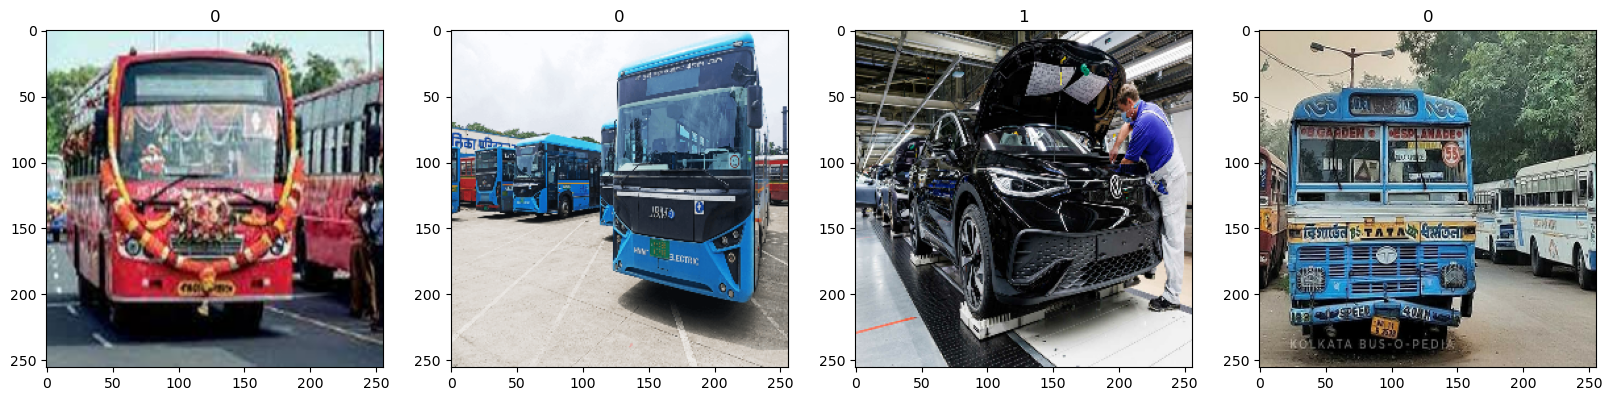

In [28]:
# Class 0= Bus; Class 1= Car
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [29]:
#Scale the Data
data = data.map(lambda x,y: (x/255, y))

In [30]:
data.as_numpy_iterator().next()

(array([[[[5.75838685e-01, 3.97070080e-01, 3.05280864e-01],
          [8.70939851e-01, 6.65340900e-01, 5.41068494e-01],
          [2.02331781e-01, 2.30395511e-01, 2.57205486e-01],
          ...,
          [5.54533601e-01, 5.35048306e-01, 5.23283601e-01],
          [4.76807356e-01, 4.55063283e-01, 4.49707270e-01],
          [4.53760237e-01, 4.36664164e-01, 4.33447510e-01]],
 
         [[6.69416368e-01, 5.03339469e-01, 4.20488656e-01],
          [9.03763115e-01, 7.46474802e-01, 6.63133800e-01],
          [1.49468631e-01, 1.89185768e-01, 1.93367749e-01],
          ...,
          [5.20076036e-01, 4.77183849e-01, 4.61352527e-01],
          [4.02743459e-01, 3.68149698e-01, 3.70138973e-01],
          [4.61627543e-01, 4.52285349e-01, 4.49435353e-01]],
 
         [[4.64454561e-01, 3.40406716e-01, 2.71745741e-01],
          [7.96351075e-01, 6.60811841e-01, 5.83238304e-01],
          [1.06441960e-01, 1.38474882e-01, 1.16092697e-01],
          ...,
          [4.69390750e-01, 4.32249069e-01, 4.1805

In [31]:
#Split the data into Training,Validation and Testing sets
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [38]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [47]:
#Build the Deep Learning Model 
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [48]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

In [50]:
#Train the model
logdir='logs' #Store the logs in logs folder

In [51]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) 

In [52]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
9/9 [==============================] - 16s 512ms/step - loss: 0.9086 - accuracy: 0.4757 - val_loss: 0.6760 - val_accuracy: 0.6562
Epoch 2/20
9/9 [==============================] - 7s 563ms/step - loss: 0.6681 - accuracy: 0.6042 - val_loss: 0.6142 - val_accuracy: 0.5938
Epoch 3/20
9/9 [==============================] - 7s 568ms/step - loss: 0.5750 - accuracy: 0.7188 - val_loss: 0.4097 - val_accuracy: 0.8438
Epoch 4/20
9/9 [==============================] - 7s 516ms/step - loss: 0.4137 - accuracy: 0.8333 - val_loss: 0.3080 - val_accuracy: 0.8906
Epoch 5/20
9/9 [==============================] - 7s 508ms/step - loss: 0.2354 - accuracy: 0.9097 - val_loss: 0.1858 - val_accuracy: 0.9219
Epoch 6/20
9/9 [==============================] - 7s 593ms/step - loss: 0.1900 - accuracy: 0.9375 - val_loss: 0.1786 - val_accuracy: 0.9531
Epoch 7/20
9/9 [==============================] - 8s 591ms/step - loss: 0.1371 - accuracy: 0.9583 - val_loss: 0.0921 - val_accuracy: 0.9688
Epoch 8/20
9/9 [===

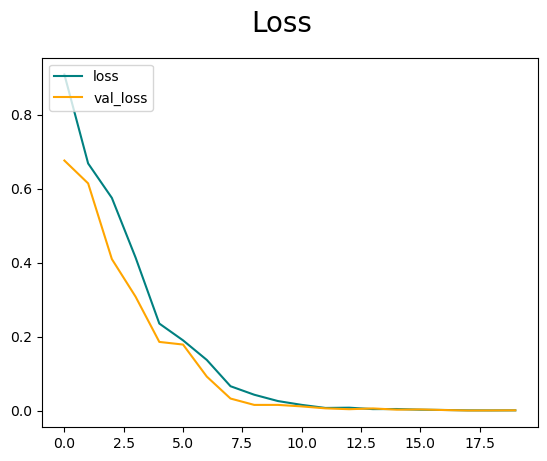

In [53]:
#Plot Performance
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

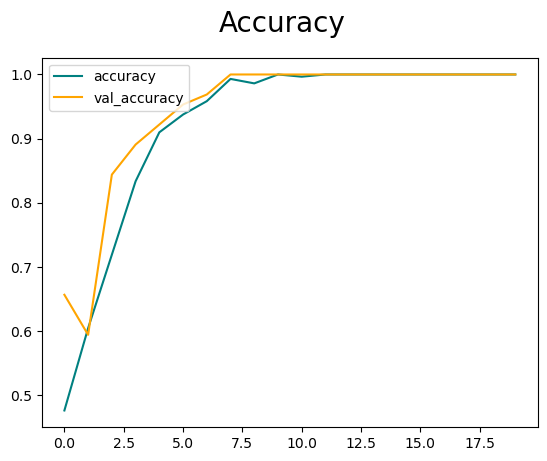

In [54]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [55]:
#Evaluate the model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [56]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [58]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 4s 4s/step


In [62]:
print ('Precision: {}, Recall: {}, Accuracy: {}'.format(pre.result().numpy(), re.result().numpy(), acc.result().numpy()))

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


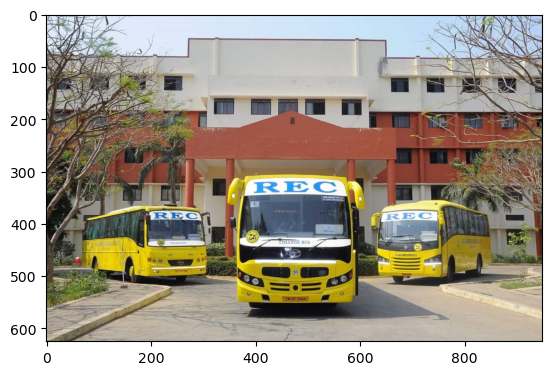

In [75]:
#Test the model

img = cv2.imread('1551372472phpGOyzEC.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

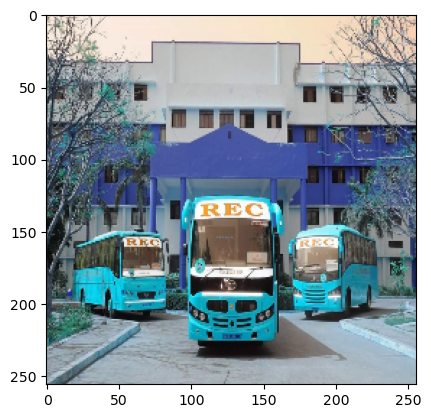

In [76]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [77]:
test_new = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 33ms/step


In [78]:
if test_new > 0.5: 
    print(f'Predicted class is Car')
else:
    print(f'Predicted class is Bus')

Predicted class is Bus


In [79]:
#Save the model
model.save(os.path.join('models','buscarmodel.h5'))